Нейронная сеть, которая будет рекомендовать соотношение матрица-наполнитель

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow import keras as keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from pandas import read_excel, DataFrame, Series
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [71]:
#Загрузим датасет:
ds1 = pd.read_excel(r"D:/мгту им Баумана/ВКР_Новикова_Е.Г/Norm/Norm.xlsx")

In [72]:
# Зададим вход и выход для модели нейронной сети: на входе будет весь датасет,  а на выходе - набор соотношений матрица-наполнитель
mn = ds1['Соотношение матрица-наполнитель']
mn_v = ds1.loc[:, ds1.columns != 'Соотношение матрица-наполнитель']

In [73]:
mn.shape

(922,)

In [74]:
mn_v.shape

(922, 13)

In [75]:
# Разделим выборку на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(mn_v, mn, test_size = 0.3, random_state = 42)

Строим полносвязную нейронную сеть (feed forward neural network). 
Выходной слой с одним линейным нейроном — для задачи регрессии. Функции активации — RELU и TANH в промежуточном слое и sigmoid в выходном. 

In [100]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid')) # sigmoid, т.к. данные от 0 до 1

In [101]:
print(model.summary()) # архитектура нашей модели

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 32)                448       
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None


In [102]:
# Компилируем сеть
# Т.к. задача регрессии, удобнее использовать mean square error(средне-квадратичная ошибка).
# В качестве метрики берем mean absolute error (средний модуль ошибки)
model.compile('RMSProp', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.compile(optimizer='RMSProp', loss='mse', metrics=['mae'])

In [103]:
# И обучаем:

history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/100
19/19 - 1s - loss: 0.0554 - mae: 0.1900 - val_loss: 0.0433 - val_mae: 0.1696 - 612ms/epoch - 32ms/step
Epoch 2/100
19/19 - 0s - loss: 0.0396 - mae: 0.1571 - val_loss: 0.0382 - val_mae: 0.1543 - 46ms/epoch - 2ms/step
Epoch 3/100
19/19 - 0s - loss: 0.0370 - mae: 0.1540 - val_loss: 0.0368 - val_mae: 0.1506 - 45ms/epoch - 2ms/step
Epoch 4/100
19/19 - 0s - loss: 0.0363 - mae: 0.1524 - val_loss: 0.0362 - val_mae: 0.1506 - 45ms/epoch - 2ms/step
Epoch 5/100
19/19 - 0s - loss: 0.0360 - mae: 0.1513 - val_loss: 0.0362 - val_mae: 0.1507 - 41ms/epoch - 2ms/step
Epoch 6/100
19/19 - 0s - loss: 0.0359 - mae: 0.1514 - val_loss: 0.0359 - val_mae: 0.1499 - 44ms/epoch - 2ms/step
Epoch 7/100
19/19 - 0s - loss: 0.0360 - mae: 0.1513 - val_loss: 0.0358 - val_mae: 0.1493 - 44ms/epoch - 2ms/step
Epoch 8/100
19/19 - 0s - loss: 0.0359 - mae: 0.1512 - val_loss: 0.0357 - val_mae: 0.1482 - 42ms/epoch - 2ms/step
Epoch 9/100
19/19 - 0s - loss: 0.0357 - mae: 0.1508 - val_loss: 0.0356 - val_mae: 0.1490 - 45m

9/9 [==============================] - 0s 914us/step


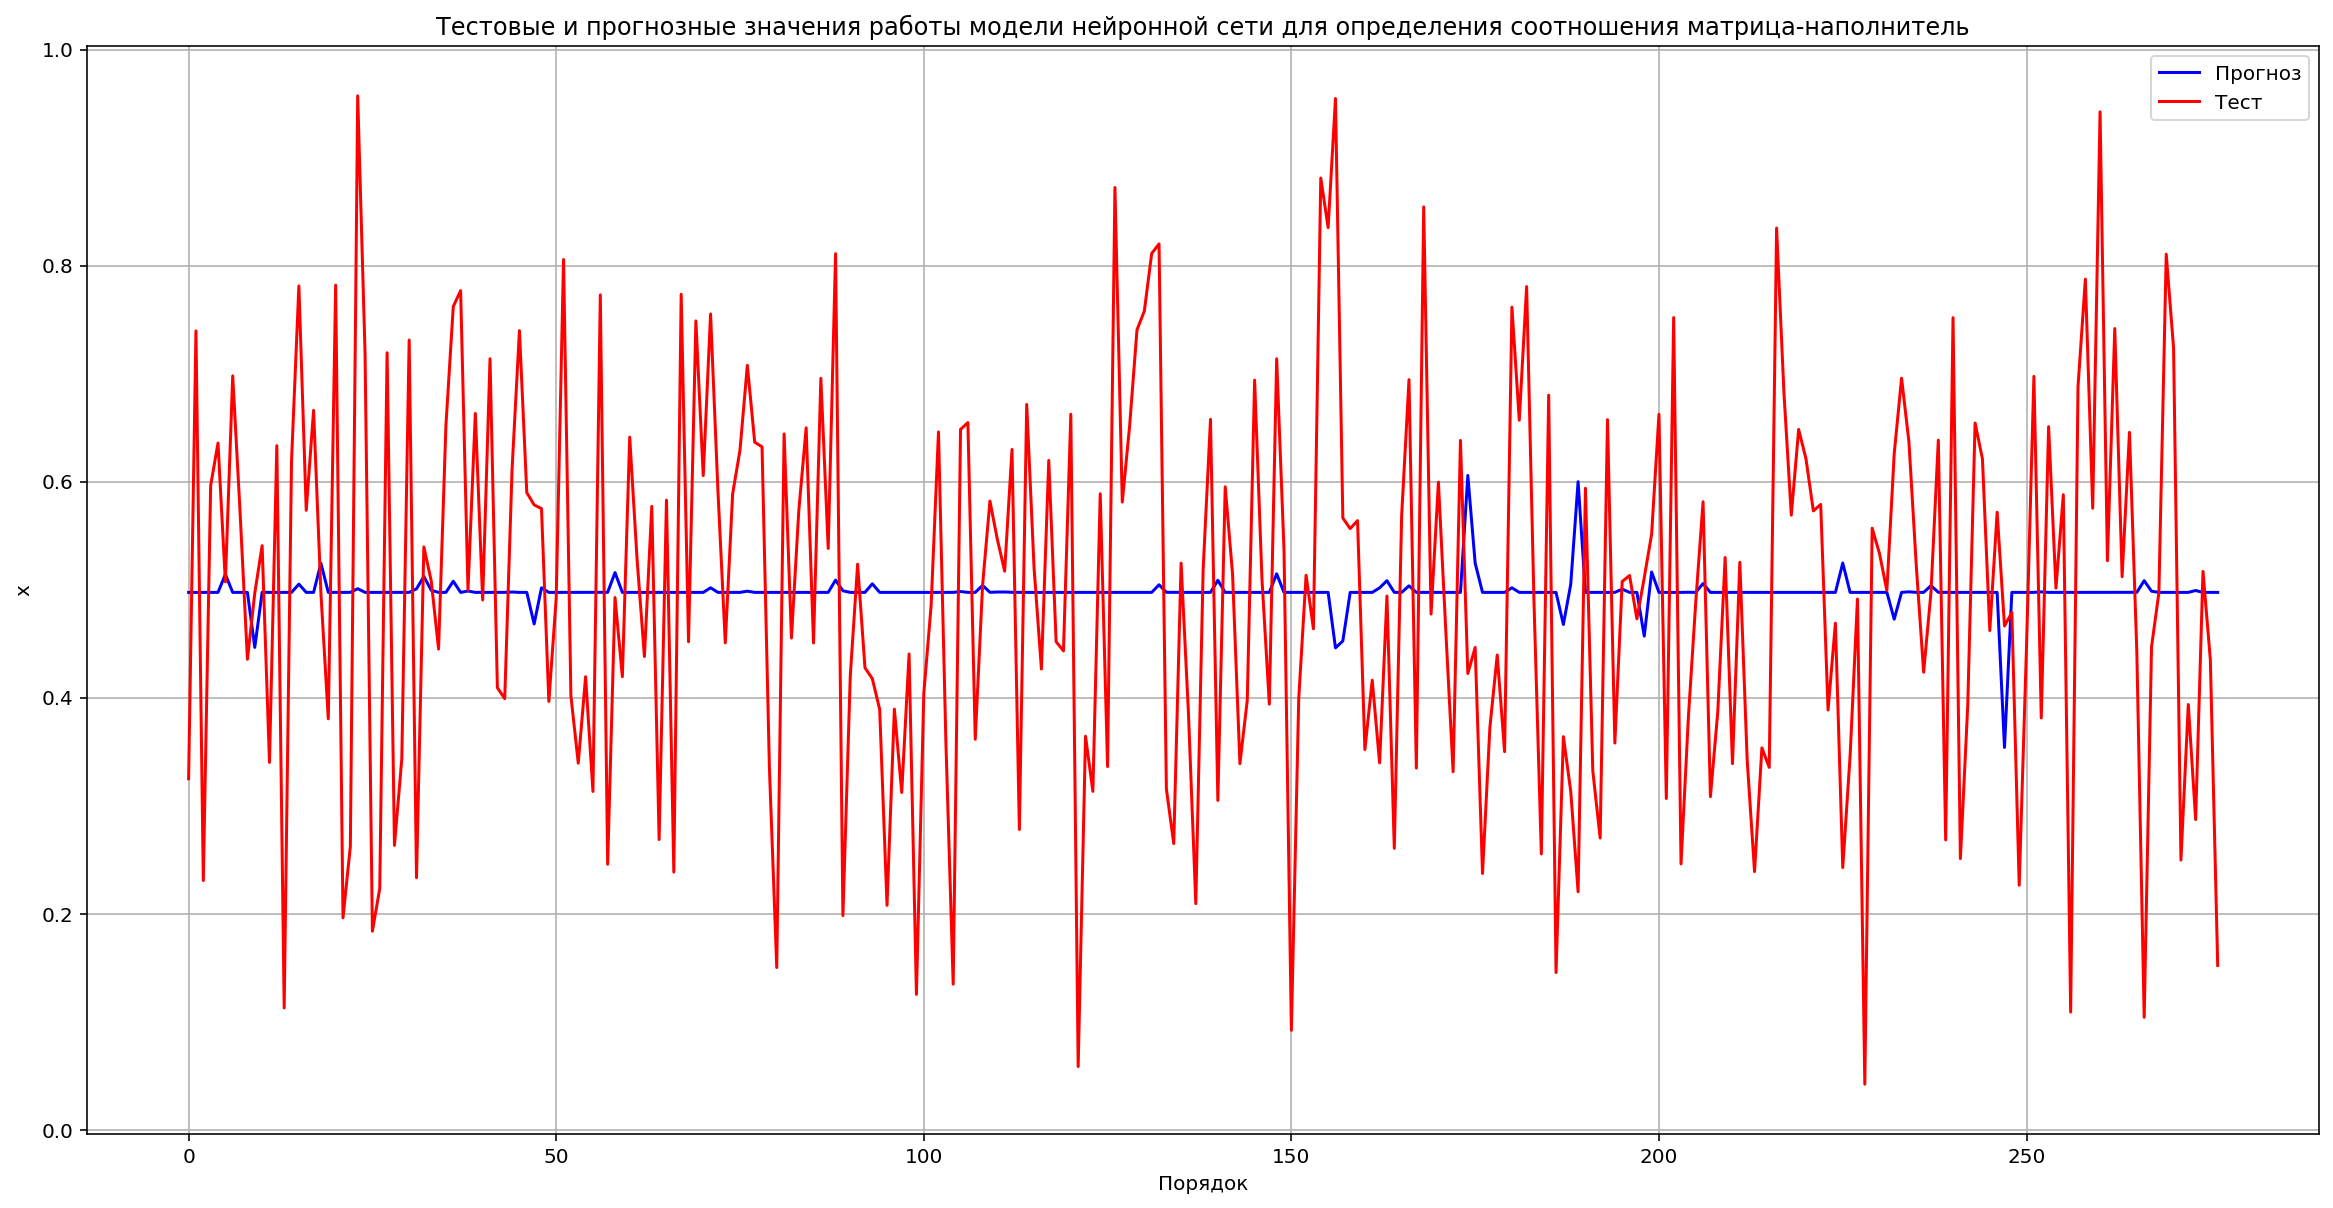

In [104]:
# Визуализация модели НС для соотношения матрица-наполнитель:
y_pred_ns = model.predict(x_test)
ns = model
# Визуализируем полученные результаты работы модели K-Neighbors Regressor:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения работы модели нейронной сети для определения соотношения матрица-наполнитель")
plt.plot(y_pred_ns, label = "Прогноз", color = 'blue')
plt.plot(y_test.values, label = "Тест", color = 'red')
plt.xlabel("Порядок")
plt.ylabel("х")
plt.legend()
plt.grid(True)


In [105]:
# Делаем прогноз. Возвращается копия предсказания в виде одномерного массива
pred = model.predict(x_test).flatten() 

9/9 [==============================] - 0s 889us/step


In [106]:
# Проверяем, какая ошибка (средний модуль отклонения) получилась:

# Средний модуль отклонения 
err = np.mean(abs(pred - y_test))
print(err)

0.1510420057202188


И получаем довольно хорошую ошибку при том, что вся процедура подбора модели предсказания прошла без нашего участия. В случае с классической регрессией пришлось бы посидеть немало времени, чтобы сделать необходимые преобразования исходных данных, которые можно было бы использовать для построения функции регрессии. Но в этом случае бонусом было бы то, что мы смогли бы увидеть полученную функцию. В случае нейронки полученная модель — «черный ящик».

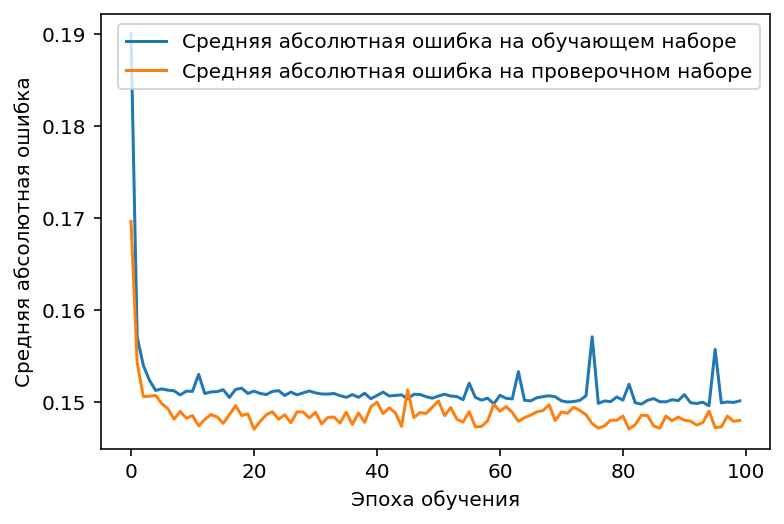

In [107]:
# Считаем графики ошибки
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

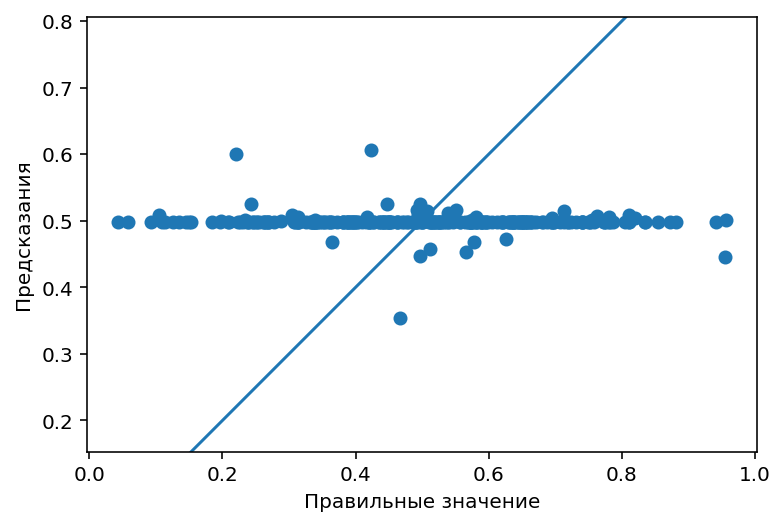

In [108]:
# Разброс предсказаний может показать перекос, если есть
plt.scatter(y_test, pred) 
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

Видно, что результаты предсказания довольно плохо укладываются относительно верных результатов. Либо ошибка в данных, либо что-то некорректно...

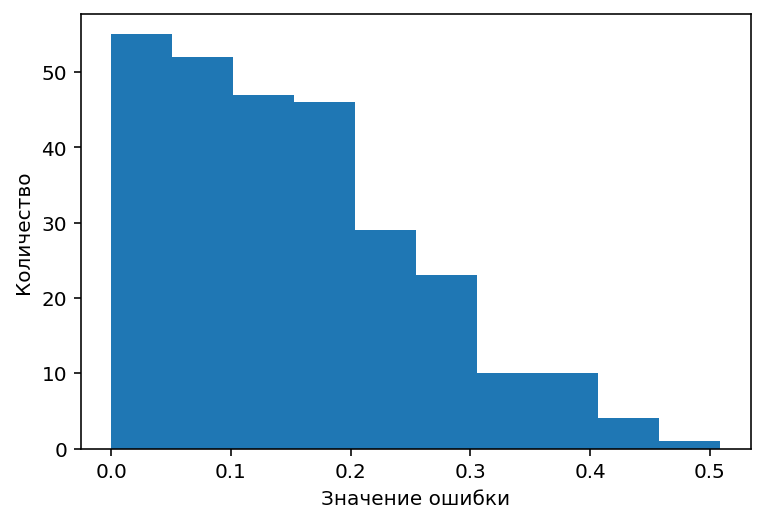

In [109]:
# Гистограмма ошибок следующая:

#Разность предсказанного и правильного ответа
error = pred - y_test
#Построение гистограммы
plt.hist(abs(error), bins = 10)
plt.xlabel("Значение ошибки")
plt.ylabel("Количество")
plt.show()

<AxesSubplot:>

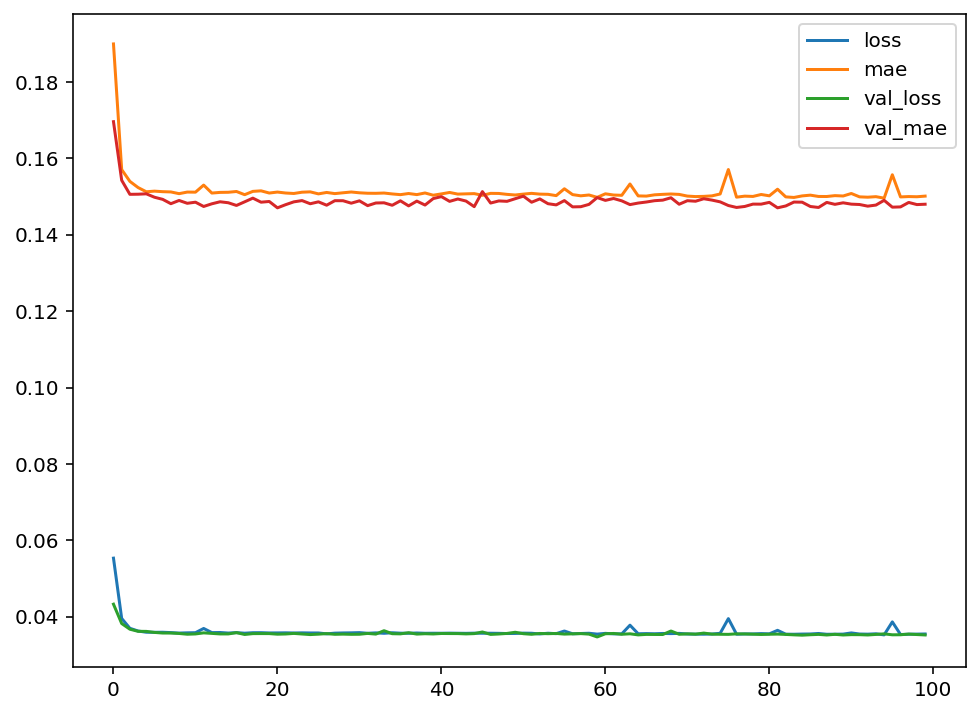

In [110]:
pd.DataFrame(history.history).plot(figsize=(8,6)) # метрики и функции потерь

In [111]:
# оценим модель:
mae_ns_train = mean_absolute_error(y_train, model.predict(x_train.values))
mae_ns_test = mean_absolute_error(y_test, model.predict(x_test.values))
mse_ns_train = mean_squared_error(y_train, model.predict(x_train.values))
mse_ns_test = mean_squared_error(y_test, model.predict(x_test.values))
R2_ns_train = r2_score(y_train, model.predict(x_train.values))
R2_ns_test = r2_score(y_test, model.predict(x_test.values))

print('mae_ns_train на тренировочной выборке: %.3f' %mean_absolute_error(y_train, model.predict(x_train)))
print('mae_ns_test на тестовой выборке: %.3f' %mean_absolute_error(y_test, model.predict(x_test)))
print('mse_ns_train на тренировочной выборке: %.3f' %mean_squared_error(y_train, model.predict(x_train)))
print('mse_ns_test на тестовой выборке: %.3f' %mean_squared_error(y_test, model.predict(x_test)))
print("R2_ns_test на тестовой выборке: {:.2f}".format(r2_score(y_test, model.predict(x_test.values))))
print("R2_ns_train на тренировочной выборке: {:.2f}".format(r2_score(y_train, model.predict(x_train.values))))



21/21 [==============================] - 0s 931us/step
mae_ns_train на тренировочной выборке: 0.149
9/9 [==============================] - 0s 980us/step
mae_ns_test на тестовой выборке: 0.151
21/21 [==============================] - 0s 730us/step
mse_ns_train на тренировочной выборке: 0.035
9/9 [==============================] - 0s 1ms/step
mse_ns_test на тестовой выборке: 0.034
9/9 [==============================] - 0s 2ms/step
R2_ns_test на тестовой выборке: -0.02
21/21 [==============================] - 0s 341us/step
R2_ns_train на тренировочной выборке: 0.02


In [112]:
#сведем результаты работы нейросети по основным исследуемым метрикам в таблицу:
df_ns = {'Модель': ['NS_train', 'NS_test'], 'MAE': [mae_ns_train, mae_ns_test], 'MSE':[mse_ns_train, mse_ns_test], 'R2':[R2_ns_train, R2_ns_test]} 
df_ns = pd.DataFrame(df_ns)
df_ns

,Модель,MAE,MSE,R2
0,NS_train,0.149377,0.035242,0.019493
1,NS_test,0.151042,0.034279,-0.018879


Сохранение модели

In [113]:
keras_model_path_1 = "my_keras_model.h5"
model.save("D:\мгту им Баумана\ВКР_Новикова_Е.Г\model for app")

INFO:tensorflow:Assets written to: D:\мгту им Баумана\ВКР_Новикова_Е.Г\model for app\assets


INFO:tensorflow:Assets written to: D:\мгту им Баумана\ВКР_Новикова_Е.Г\model for app\assets


In [114]:
model.save(keras_model_path_1, save_format="h5")

Загрузка модели

In [115]:
reconstructed_model = keras.models.load_model(keras_model_path_1)

In [116]:
reconstructed_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 32)                448       
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
